# Video Game Sales Exploration and Prediction

In [1]:
#Import libraries
%pip install -q seaborn
%pip install -q ipywidgets
import ipywidgets as widgets
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn import metrics 

### Top 5 selling video games between 2000-2016

In [2]:
#Drop NaN rows, games before 2000, and games after 2016.
df = pd.read_csv("/drive/data/gamesales.csv")
df = df.dropna(axis=0)
df.drop(df[df['Year'] < 2000.0].index, inplace = True)
df.drop(df[df['Year'] > 2016.0].index, inplace = True)
#Displays top 5 selling games between 2000-2016
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02


### Total sales of each genre between 2000-2016

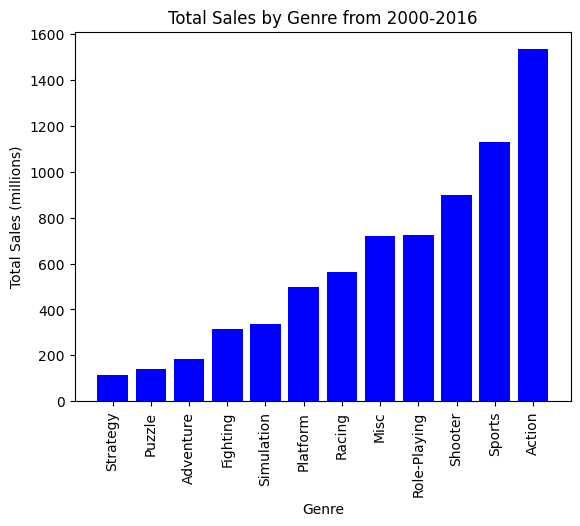

In [3]:
df2 = df.copy()
#Group the games by genre and combine their global_sales
df2 = df2.groupby(['Genre'],as_index=False).agg({'Global_Sales': 'sum'})
df2 = df2.sort_values(by = 'Global_Sales', ascending = True)
#Display the genres in ascending order.
#Shows each genre and how much they made in total compared to others. Can be used to gauge potential game success, interest, and size of audience.
plt.bar("Genre", "Global_Sales", data = df2, color = "blue")
plt.xlabel("Genre")
plt.xticks(rotation = 90)
plt.ylabel("Total Sales (millions)")
plt.title("Total Sales by Genre from 2000-2016")
plt.show()

### Comparing sales of all video games between the three big regions (millions)

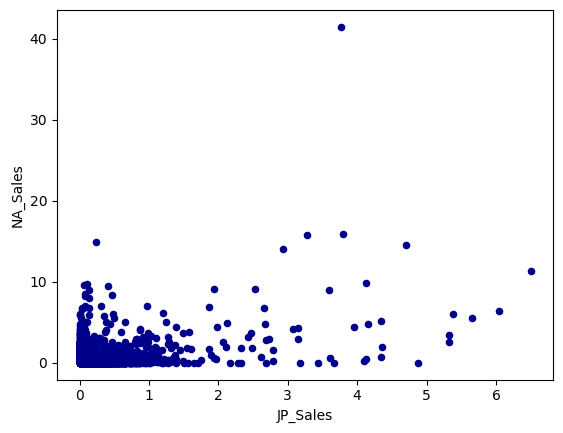

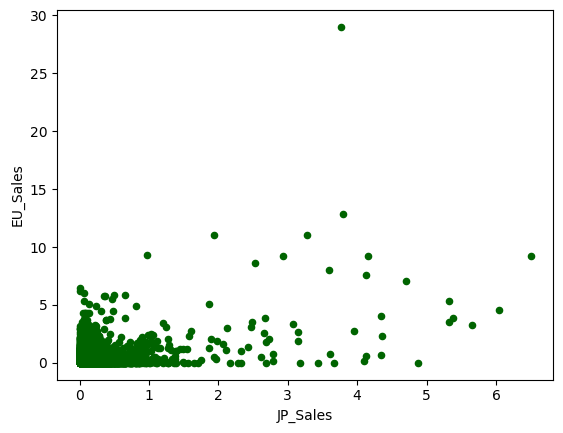

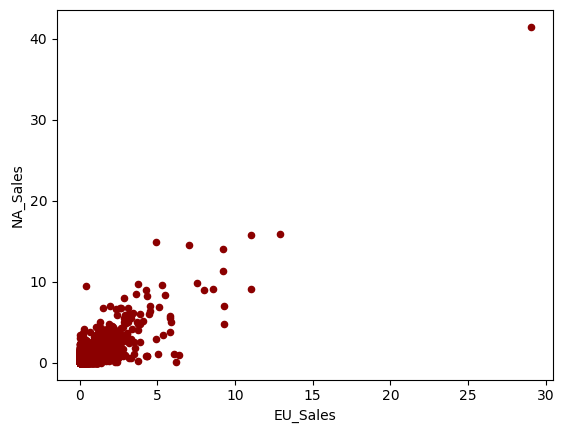

In [4]:
#These scatter plots show the correlation of sales between two countries.
#Things to take notice of: NA and EU game sales climb proportionally, 
#while JP game sales usually only do well in JP (relative to population).
#Therefore, games shouldn't targeted at JP if the main goal is profit.
scat = df.plot.scatter(x='JP_Sales', y='NA_Sales', c='DarkBlue')
scat2 = df.plot.scatter(x='JP_Sales', y='EU_Sales', c='DarkGreen')
scat3 = df.plot.scatter(x='EU_Sales', y='NA_Sales', c='DarkRed')
plt.show()

### Machine Learning Model Training and Accuracy

R-squared Error in training: 0.0072
R-squared Error in test: 0.006
This means, in testing, only 0.6% of target variance can be explained by the model.


<AxesSubplot:>

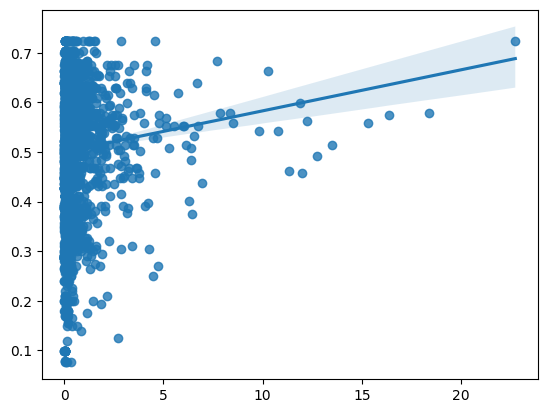

In [5]:
df3 = df.copy()

df3.replace({'Platform':
            {'Wii':0, 'DS':1, 'X360':2, 'PS3':3, 'PS2':4, 'GBA':5, '3DS':6, 'PS4':7, 'XB':8, 'PC':9, 'PSP':10, 
             'XOne':11, 'GC':12, 'WiiU':13, 'GB':14, 'PS':15, 'N64':16, '2600':17, 'PSV':18, 'DC':19, 'WS':20}}, inplace=True)
df3.replace({'Genre':
            {'Sports':0, 'Racing':1, 'Platform':2, 'Misc':3, 'Simulation':4, 'Action':5, 'Role-Playing':6, 
             'Puzzle':7, 'Shooter':8, 'Fighting':9, 'Adventure':10, 'Strategy':11}}, inplace=True)

#Train the model
X = df3.drop(['Rank', 'Name', 'Year', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
Y = df3['Global_Sales']
X_train, X_test, Y_train, Y_test = train_test_split(X.values, Y.values, test_size = 0.2, random_state=42)
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, Y_train)
training_data_prediction = lin_reg_model.predict(X_train)

#Output error scores and accuracy
train_error_score = metrics.r2_score(Y_train, training_data_prediction) 
print("R-squared Error in training:", round(train_error_score, 4))
Y_pred = lin_reg_model.predict(X_test)
test_error_score = metrics.r2_score(Y_test, Y_pred) 
print("R-squared Error in test:", round(test_error_score, 4))
print("This means, in testing, only 0.6% of target variance can be explained by the model.")
#The graph below visualizes and proves the very low correlation that platform and genre have on total sales.
#Things that can't be put in a graph, such as marketing and developer history, play a larger role in video game sales than their genres and platforms.
sns.regplot(x=Y_test, y=Y_pred)

### Estimate how much money a video game would make if it were to be developed. Select the genre of the game and the platform it would be released on, then click 'Estimate Sales'

In [6]:
#Create menus and button
menu1 = widgets.Dropdown(
    options=df.Platform.unique().tolist(), 
    description='Platform:')        
menu2 = widgets.Dropdown(
    options=df.Genre.unique().tolist(),
    description='Genre:')
button = widgets.Button(description="Estimate Sales")
out = widgets.Output()

def on_button_clicked(_):
      with out:
        X_new = np.array([menu1.options.index(menu1.value), menu2.options.index(menu2.value)]).reshape(1, -1)
        result = round(lin_reg_model.predict(X_new)[0], 3)
        print("A game for the " + str(menu1.value) + " console in the " + str(menu2.value) + 
              " genre will make $" + str(result) + " million dollars.")
        #Results should be taken with a grain of salt because of the low accuracy. Results should be interpreted relatively rather than literally.
        #For example, view the data as "oh, this combination will sell more copies in general than the other combination."

button.on_click(on_button_clicked)
widgets.VBox([menu1,menu2,button,out])